In [1]:
library("tseries")

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



# 2 Лабораторная работа: GARCH(p, q)

## Пользовательские функции.

In [2]:
set.seed(1)

# GenerateGRACH_1_0<-function(a0,a1,n){
#     epsilon <- rnorm(n)
#     sigma <- numeric(n)
#     h <- numeric(n)
#     sigma[1] <- sqrt(a0 / (1 - a1))
#     h[1] <- epsilon[1] * sigma[1]
#     for (i in 2:n) {
#       sigma[i] <- sqrt(a0 + a1 * h[i - 1]^2)
#       h[i] <- epsilon[i] * sigma[i]
#     }
#     return( list(sigma = sigma, h = h) )
# }

GenerateGRACH_1_1<-function(a0,a1,n, b1 = 0){

    eps <- rep(0, n)
    sigsq <- rep(0,n)
    for (i in 2:n) {
      sigsq[i] = a0 + a1*(eps[i-1]^2) + b1*sigsq[i-1]
      eps[i] <- rnorm(1)*sqrt(sigsq[i])
    }
    return( list(sigma = sigsq, h = eps) )
}

GenerateGRACH_3_0 <- function(a = c(0.1, 0.2, 0.23, 0.2), n = 1100) {
    eps <- numeric(n)
    sigsq <- numeric(n)
    
    sigsq[1:3] <- a[1]
    eps[1:3] <- rnorm(3) * sqrt(sigsq[1:3])
    
    for (i in 4:n) {
        sigsq[i] = a[1] + (a[2] * eps[i - 1]^2 + a[3] * eps[i - 2]^2 + a[4] * eps[i - 3]^2)
        eps[i] <- rnorm(1) * sqrt(sigsq[i])
    }
    
    return(list(sigma = sigsq, h = eps))
}

PredictARCH_3 <- function(a_est,h, k=1100){
    n <- length(h)
    
    for (i in n:k ) {
        h[i+1] <- a_est[1] + ( a_est[2]*h[i] +  a_est[3]*h[i-1] + a_est[4]*h[i-2] )
    }
    return ( h[n:k] )
}


# GenerateARCH_1<-function(a0,a1,n){
#     e <- NULL
#     e[1] <- rnorm(1)
#     for (i in 2:n) {
#         e[i] <- rnorm(1)*(a0+a1*(e[i-1])^2)
#     }
#     return (e)
# }


Estimation_MNK_ARCH_1<-function(ARCH_1){
    
    numerator <- 0
    denominator <- 0
    
    for(i in 2:length(ARCH_1)){
        numerator <- numerator + ( ARCH_1[i]^2 * (ARCH_1[i-1]^2 - 1) )
        denominator <- denominator + ( ARCH_1[i-1]^4 - ARCH_1[i-1]^2 )   
    }
    a_0 <- numerator / denominator
    
    numerator <- 0

    for(i in 2:length(ARCH_1)){
        numerator <- numerator + ARCH_1[i]^2 - a_0*ARCH_1[i-1]**2
    }
    a_1 <- numerator/length(ARCH_1)

    return( list(a_0 = a_0, a_1 = a_1) )
}

Я дурак, или лыжи едут не так?<br>
Оценка параметров показывает не те значения.

## 1. График
Построить график стационарного процесса $\{h_n\}$ и график волатильности $ \{\sigma_n\}$ процесса $GARCH(1,0)$, из $n = 1000$ наблюдений.


In [3]:
garch_1 <- GenerateGRACH_1_1(0.1, 0.7, 1000)

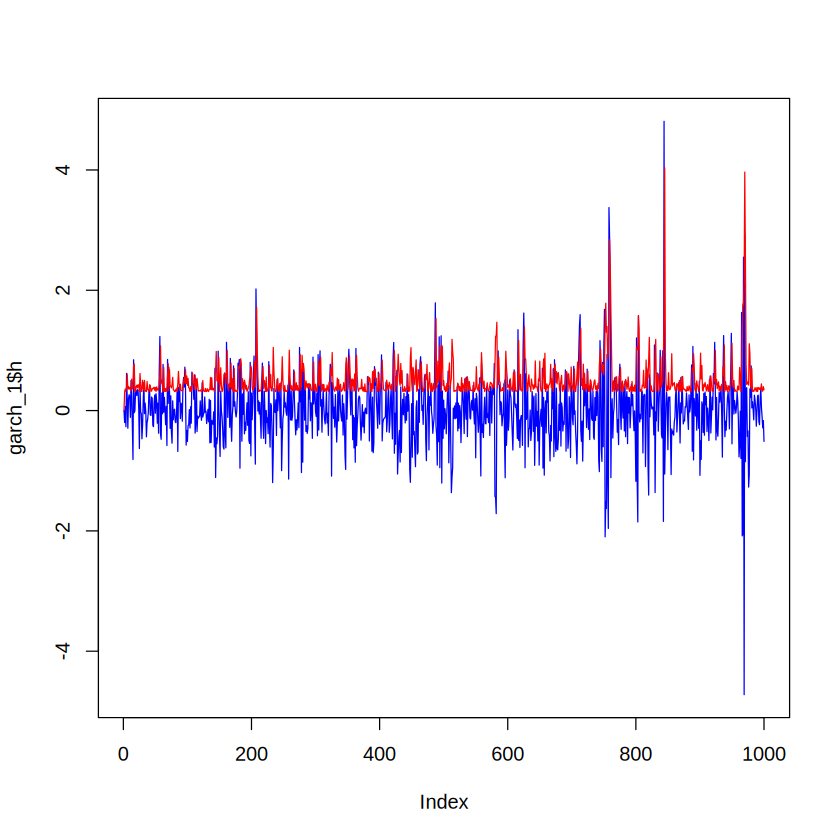

In [4]:
plot(garch_1$h, type = "l", col = "blue")
lines(sqrt(garch_1$sigma), col = "red")

## 2. Оценка параметров МНК

In [5]:
Estimation_MNK_ARCH_1(garch_1$h)

$a_0
[1] 0.3624436

$a_1
[1] 0.2259771

## 3. Оценить параметры 𝑎0, 𝑎1 при помощи функции `garch()`


In [6]:
garch(garch_1$h,order=c(0,1))


 ***** ESTIMATION WITH ANALYTICAL GRADIENT ***** 


     I     INITIAL X(I)        D(I)

     1     3.369155e-01     1.000e+00
     2     5.000000e-02     1.000e+00

    IT   NF      F         RELDF    PRELDF    RELDX   STPPAR   D*STEP   NPRELDF
     0    1 -9.005e+01
     1    3 -1.453e+02  3.80e-01  5.57e-01  1.5e-01  8.1e+03  1.0e-01  2.26e+03
     2    5 -1.916e+02  2.41e-01  2.60e-01  1.7e-01  4.7e+00  1.0e-01  1.07e+03
     3    6 -2.135e+02  1.03e-01  1.56e-01  1.6e-01  4.9e+00  1.0e-01  2.10e+01
     4    7 -2.167e+02  1.44e-02  1.10e-01  1.3e-01  2.0e+00  1.0e-01  1.91e+01
     5    8 -2.377e+02  8.85e-02  9.86e-02  9.6e-02  2.0e+00  1.0e-01  5.06e+00
     6    9 -2.427e+02  2.06e-02  4.12e-02  1.1e-01  1.9e+00  1.0e-01  7.10e-01
     7   10 -2.451e+02  1.00e-02  3.29e-02  8.4e-02  1.6e+00  1.0e-01  1.44e-01
     8   11 -2.470e+02  7.44e-03  1.15e-02  4.9e-02  0.0e+00  6.3e-02  1.15e-02
     9   12 -2.472e+02  7.29e-04  6.15e-04  5.6e-03  0.0e+00  8.1e-03  6.15e-04
    10   1


Call:
garch(x = garch_1$h, order = c(0, 1))

Coefficient(s):
    a0      a1  
0.1169  0.6508  


 ## 4. `𝐺𝐴𝑅𝐶𝐻(3,0)`

In [7]:
garch3 <- GenerateGRACH_3_0()

Параметры заданные при симуляции:<br>
`0.1, 0.2, 0.23, 0.2`

### Разделение на тестовую и обубчающую выборки

In [8]:
train_set <- garch3$h[1:990]
test_set <- garch3$h[991:1100]

In [9]:
coefs_GARCH <- garch(train_set,order=c(0,3))$coef


 ***** ESTIMATION WITH ANALYTICAL GRADIENT ***** 


     I     INITIAL X(I)        D(I)

     1     2.592616e-01     1.000e+00
     2     5.000000e-02     1.000e+00
     3     5.000000e-02     1.000e+00
     4     5.000000e-02     1.000e+00

    IT   NF      F         RELDF    PRELDF    RELDX   STPPAR   D*STEP   NPRELDF
     0    1 -1.333e+02
     1    3 -1.582e+02  1.58e-01  1.91e-01  1.5e-01  3.0e+03  1.0e-01  2.88e+02
     2    4 -1.719e+02  7.96e-02  8.72e-02  1.7e-01  3.2e+00  1.0e-01  4.02e+01
     3    6 -1.730e+02  5.89e-03  2.89e-02  7.9e-02  1.0e+03  4.2e-02  5.10e+01
     4    7 -1.751e+02  1.23e-02  1.57e-02  7.0e-02  2.0e+00  4.2e-02  3.08e-01
     5    8 -1.758e+02  4.05e-03  6.26e-03  1.0e-01  2.0e+00  4.2e-02  2.10e-01
     6    9 -1.760e+02  1.09e-03  7.50e-03  1.8e-01  1.9e+00  8.4e-02  7.79e-02
     7   10 -1.764e+02  2.16e-03  1.56e-02  1.6e-01  3.2e+00  8.4e-02  3.18e-01
     8   13 -1.774e+02  5.68e-03  1.04e-02  2.7e-02  3.4e+00  1.3e-02  5.19e-01
     9   14 -1

In [10]:
coefs_GARCH

a0        a1        a2        a3 
0.1158473 0.2115123 0.1790227 0.2473105

In [11]:
predictARCH3_set <- PredictARCH_3(coefs_GARCH, train_set)
predictARCH3_set

[1] 0.4105988 0.3694929 0.5532219 0.4005536 0.3909881 0.4070719 0.3710049
  [8] 0.3638900 0.3599060 0.3488698 0.3440627 0.3400850 0.3356537 0.3328155
 [15] 0.3304381 0.3283312 0.3267581 0.3254602 0.3243830 0.3235338 0.3228404
 [22] 0.3222752 0.3218216 0.3214529 0.3211540 0.3209126 0.3207168 0.3205583
 [29] 0.3204300 0.3203260 0.3202419 0.3201737 0.3201186 0.3200739 0.3200377
 [36] 0.3200084 0.3199847 0.3199655 0.3199499 0.3199373 0.3199271 0.3199188
 [43] 0.3199122 0.3199067 0.3199024 0.3198988 0.3198959 0.3198936 0.3198917
 [50] 0.3198902 0.3198890 0.3198880 0.3198871 0.3198865 0.3198860 0.3198855
 [57] 0.3198852 0.3198849 0.3198847 0.3198845 0.3198843 0.3198842 0.3198841
 [64] 0.3198840 0.3198840 0.3198839 0.3198839 0.3198838 0.3198838 0.3198838
 [71] 0.3198838 0.3198838 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837
 [78] 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837
 [85] 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837
 [92] 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837
 [99] 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837
[106] 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837 0.3198837

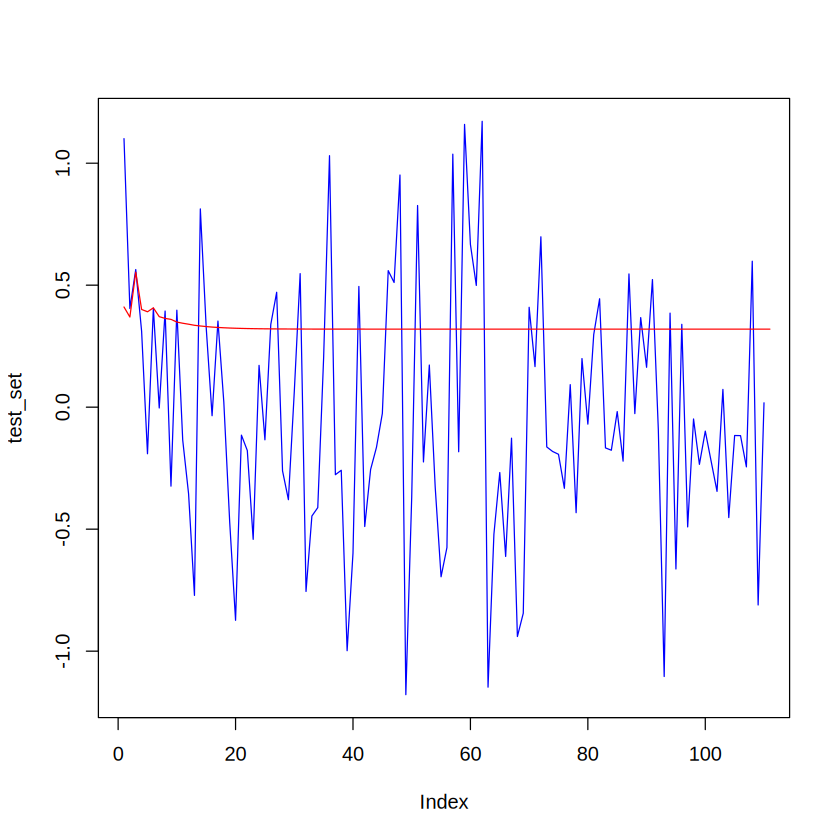

In [13]:
plot(test_set, type = "l", col = "blue")
lines(predictARCH3_set, col = "red")

## 5. `𝐺𝐴𝑅𝐶𝐻(1,1)`

In [15]:
garch11 <- GenerateGRACH_1_1(.3, .4, 1000, .2)$h

In [16]:
garch(garch11,order=c(1,1))


 ***** ESTIMATION WITH ANALYTICAL GRADIENT ***** 


     I     INITIAL X(I)        D(I)

     1     6.994856e-01     1.000e+00
     2     5.000000e-02     1.000e+00
     3     5.000000e-02     1.000e+00

    IT   NF      F         RELDF    PRELDF    RELDX   STPPAR   D*STEP   NPRELDF
     0    1  3.539e+02
     1    3  3.371e+02  4.74e-02  7.83e-02  7.1e-02  2.8e+03  1.0e-01  1.08e+02
     2    5  3.357e+02  4.18e-03  4.24e-03  5.4e-03  1.7e+02  1.0e-02  3.98e+01
     3    8  3.265e+02  2.73e-02  2.79e-02  4.6e-02  2.1e+00  8.0e-02  6.18e+00
     4   10  3.251e+02  4.46e-03  4.52e-03  9.5e-03  2.1e+01  1.6e-02  5.30e+00
     5   12  3.248e+02  8.54e-04  8.54e-04  1.9e-03  6.6e+01  3.2e-03  4.50e+00
     6   15  3.227e+02  6.37e-03  6.37e-03  1.6e-02  3.1e+00  2.6e-02  4.55e+00
     7   17  3.144e+02  2.58e-02  2.68e-02  1.4e-01  2.1e+00  2.0e-01  4.59e+00
     8   19  3.135e+02  2.73e-03  2.06e-02  9.3e-02  2.6e+00  9.1e-02  3.57e+00
     9   20  3.086e+02  1.57e-02  1.74e-02  1.0e-01 


Call:
garch(x = garch11, order = c(1, 1))

Coefficient(s):
    a0      a1      b1  
0.2752  0.3751  0.2767  
